In [ ]:
#TODO: Approximate MNIST signal in non-federated learning

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 5 #30
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

Define Model class

In [5]:
import copy

class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the first convolutional layer (input channels: 1, output channels: 20, kernel size: 7)
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        # Initialize the second convolutional layer (input channels: 20, output channels: 40, kernel size: 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        # Initialize the max pooling layer with kernel size 2x2 and stride 2
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        # Initialize the flatten layer to convert 2D feature maps to 1D vectors
        self.flatten = torch.nn.Flatten()
        # Initialize the linear (fully connected) layer (input features: 2560, output features: 10)
        self.linear = torch.nn.Linear(2560, 10)
        # Define the non-linearity to use (ReLU activation function)
        self.non_linearity = torch.nn.functional.relu
        # Create a dictionary to track the layers by name for easier parameter management
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        # Pass the input batch through the first convolutional layer and apply the non-linearity
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        # Pass the result through the second convolutional layer and apply the non-linearity
        out = self.conv2(out)
        out = self.non_linearity(out)
        # Apply max pooling
        out = self.maxpool(out)
        # Flatten the output to feed it into the linear layer
        out = self.flatten(out)
        # Pass the flattened output through the linear layer to get the final output
        out = self.linear(out)
        return out

    def get_track_layers(self):
        # Return the dictionary of layers being tracked
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        # Apply the provided parameters to the network's layers
        with torch.no_grad():  # Disable gradient tracking
            for layer_name in parameters_dict:
                # Zero out the weights and biases before applying new parameters
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                # Apply new weights and biases from the dictionary
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self, deep_copy=True):
        # Retrieve the parameters of the tracked layers
        parameters_dict = dict()
        for layer_name in self.track_layers:
            # Store the weights and biases of each tracked layer in a dictionary
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        if deep_copy:
            # Return a deep copy of the parameters if specified
            params_clone = copy.deepcopy(parameters_dict)
            return params_clone
        else:
            # Return the parameters without deep copying
            return parameters_dict

    def batch_accuracy(self, outputs, labels):
        # Calculate the accuracy of predictions in the batch
        with torch.no_grad():  # Disable gradient tracking
            # Get the index of the max log-probability (predicted label)
            _, predictions = torch.max(outputs, dim=1)
            # Return the ratio of correct predictions to total predictions
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        # Process a single batch of data
        images, labels = batch
        # Get the model outputs for the input images
        outputs = self(images)
        # Compute the cross-entropy loss between outputs and labels
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        # Calculate the accuracy for the batch
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        # Train the model on the provided dataset
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        # Initialize the optimizer with the model parameters and learning rate
        optimizer = opt(self.parameters(), lr)
        history = []
        # Loop over epochs
        for epoch in range(epochs):
            losses = []
            accs = []
            # Loop over batches of data
            for batch in dataloader:
                # Process the batch to get loss and accuracy
                loss, acc = self._process_batch(batch)
                # Backpropagate the loss
                loss.backward()
                # Update the model parameters
                optimizer.step()
                # Reset the gradients for the next step
                optimizer.zero_grad()
                # Detach the loss from the computation graph
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            # Compute average loss and accuracy for the epoch
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            # Store the average loss and accuracy
            history.append((avg_loss, avg_acc))
        # Return the training history
        return history

    def evaluate(self, dataset, batch_size=128):
        # Evaluate the model on the provided dataset
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():  # Disable gradient tracking
            for batch in dataloader:
                # Process the batch to get loss and accuracy
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        # Compute average loss and accuracy
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)


Define Client class

In [6]:
class Client:
    def __init__(self, client_id, dataset):
        # Initialize the client with a unique client ID and an associated dataset
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        # Return the size (number of samples) of the client's dataset
        return len(self.dataset)

    def get_client_id(self):
        # Return the client's unique ID
        return self.client_id

    def __difference(self, params1: dict, params2: dict):
        # Calculate the difference between two sets of parameters (params1 - params2)
        diff = {}
        for layer in params1.keys():
            diff[layer] = {}
            for key in params1[layer].keys():
                # Subtract the corresponding parameter values
                diff[layer][key] = params1[layer][key] - params2[layer][key]
        return diff

    def train(self, parameters_dict):
        # Initialize a new instance of the FederatedNet model and move it to the appropriate device
        net = to_device(FederatedNet(), device)
        # Apply the given parameters to the model
        net.apply_parameters(parameters_dict)
        # Get and store the initial parameters (weights and biases)
        wt = net.get_parameters(deep_copy=True)
        # Train the model on the client's dataset and record the training history
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        # Print the final loss and accuracy for this client after training
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        # Get the updated parameters after training
        wt_plus_1 = net.get_parameters(deep_copy=True)
        # Calculate the difference between the initial and updated parameters
        update = self.__difference(wt, wt_plus_1)
        # Return the parameter updates to be used in the federated learning process
        return update


Setup clients

In [7]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

Helper methods

In [8]:
def diff_l2_norm(wt, wt_plus_1):
    # Calculate the L2 norm (Euclidean distance) between two sets of model parameters
    total_diff = 0
    for layer in wt.keys():
        for key in wt[layer].keys():
            # Compute the difference between the corresponding parameters in wt and wt_plus_1
            diff = wt[layer][key] - wt_plus_1[layer][key]
            # Accumulate the sum of squares of the differences
            total_diff += torch.sum(diff ** 2)
    # Calculate the square root of the accumulated sum to get the L2 norm
    l2_norm = torch.sqrt(total_diff)
    return l2_norm

def reconstruct_wt_plus_1(global_params, client_updates):
    # Reconstruct the updated model parameters (wt_plus_1) by subtracting client updates from the global parameters
    wt_plus_1 = {}
    for layer in global_params.keys():
        wt_plus_1[layer] = {}
        for key in global_params[layer].keys():
            # Subtract the client's updates from the global parameters
            wt_plus_1[layer][key] = global_params[layer][key] - client_updates[layer][key]
    return wt_plus_1

import numpy as np
def flatten_dict_to_vector(d):
    # Flatten a dictionary of model parameters into a single vector for easier manipulation
    flat_list = []
    shapes = {}

    for k1, v1 in d.items():
        for k2, tensor in v1.items():
            # Store the shape of each tensor for later reconstruction
            shapes[f'{k1}_{k2}'] = tensor.shape
            # Check if the tensor is on GPU; if so, move it to CPU for further processing
            if tensor.is_cuda:
                tensor = tensor.cpu()
            # Flatten the tensor and add it to the flat list
            flat_list.extend(tensor.flatten().numpy())

    # Convert the flat list into a numpy array
    flat_vector = np.array(flat_list)
    return flat_vector, shapes

def restore_vector_to_dict(flat_vector, shapes):
    # Restore a flattened vector back into a dictionary of tensors with their original shapes
    restored_dict = {}
    offset = 0

    # Determine the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for k, shape in shapes.items():
        size = np.prod(shape)
        # Extract a portion of the flat vector corresponding to the current tensor shape
        tensor_flat = flat_vector[offset:offset + size]
        # Reshape the flat vector back into its original tensor shape and move it to the appropriate device
        tensor = tensor_flat.clone().detach().reshape(shape).to(device)

        k1, k2 = k.split('_')
        if k1 not in restored_dict:
            restored_dict[k1] = {}
        restored_dict[k1][k2] = tensor

        offset += size

    return restored_dict

Start server

In [9]:
from time import time

# Initialize a list to store errors and record the start time
errors = []
start = time()

# Initialize the global model and move it to the appropriate device (CPU or GPU)
global_net = to_device(FederatedNet(), device)

# Initialize a list to store the training history
history = []

# Loop over the number of federated learning rounds
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))

    # Get the current global model parameters
    curr_parameters = global_net.get_parameters()

    # Create a deep copy of the current parameters to store the new aggregated parameters
    new_parameters = copy.deepcopy(curr_parameters)

    # Initialize a list to collect updates from all clients
    updates = []

    # Get updates from each client by training their local models
    for client in clients:
        update = client.train(curr_parameters)
        updates.append(update)

    # Initialize a list to store the processed (genetically altered) updates
    processed_updates = []

    # Apply Gaussian Algorithm (GA) to the updates for dimensionality reduction
    for update in updates:
        # Flatten the update dictionary to a vector for easier manipulation
        flat_vector, shapes = flatten_dict_to_vector(update)
        d = flat_vector.size
        q = 10
        random_seed = 42

        # Generate a random Gaussian matrix for dimensionality reduction
        np.random.seed(random_seed)
        G_np = np.random.normal(0, 1, size=(d, int(q)))
        # TODO: take G out of the loop
        # TODO: G should be different in each round
        G = torch.tensor(G_np, dtype=torch.float32)

        # Project the update vector into a lower-dimensional space
        # TODO: remove scaling
        w = torch.matmul(G.T, torch.tensor(flat_vector)) / q

        # Reconstruct the vector back to its original dimensionality
        delta = torch.matmul(G, w)
        

        # Restore the flattened vector back to a dictionary format
        restored_wt = restore_vector_to_dict(delta, shapes)
        processed_updates.append(restored_wt)

    # Aggregate the processed updates into the global model
    for update in processed_updates:
        # Reconstruct the client's model parameters after applying the update
        client_parameters = reconstruct_wt_plus_1(curr_parameters, update)

        # Compute the fraction of the total training data that the client has
        fraction = client.get_dataset_size() / total_train_size

        # Update the global parameters by adding the client's weighted contribution
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * (client_parameters[layer_name]['weight'])
            new_parameters[layer_name]['bias'] += fraction * (client_parameters[layer_name]['bias'])

    # Apply the newly aggregated parameters to the global model
    global_net.apply_parameters(new_parameters)

    # Evaluate the global model on the training and validation datasets
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)

    # Print the evaluation results after each round
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1,
            round(train_loss, 4), round(dev_loss, 4), round(dev_acc, 4)))

    # Append the results to the training history
    history.append((train_loss, dev_loss, dev_acc))


Start Round 1 ...
client_0: Loss = 0.4932, Accuracy = 0.8505
client_1: Loss = 0.4921, Accuracy = 0.8479
client_2: Loss = 0.5181, Accuracy = 0.8395
client_3: Loss = 0.4744, Accuracy = 0.8593
client_4: Loss = 0.5127, Accuracy = 0.8428
client_5: Loss = 0.5221, Accuracy = 0.8464
client_6: Loss = 0.4924, Accuracy = 0.8489
client_7: Loss = 0.5024, Accuracy = 0.8497
After round 1, train_loss = 733.627, dev_loss = 740.5712, dev_acc = 0.0983

Start Round 2 ...
client_0: Loss = 2.3206, Accuracy = 0.1251
client_1: Loss = 2.3237, Accuracy = 0.1112
client_2: Loss = 2.3191, Accuracy = 0.1158
client_3: Loss = 2.3224, Accuracy = 0.1107
client_4: Loss = 2.3151, Accuracy = 0.1194
client_5: Loss = 2.3285, Accuracy = 0.1139
client_6: Loss = 2.3024, Accuracy = 0.1413
client_7: Loss = 2.3189, Accuracy = 0.1185
After round 2, train_loss = 46755488.0, dev_loss = 46969460.0, dev_acc = 0.1164

Start Round 3 ...
client_0: Loss = 28.0412, Accuracy = 0.1033
client_1: Loss = 28.7023, Accuracy = 0.0937
client_2: Los

In [10]:
print('time took:', time() - start)

time took: 1096.000406742096


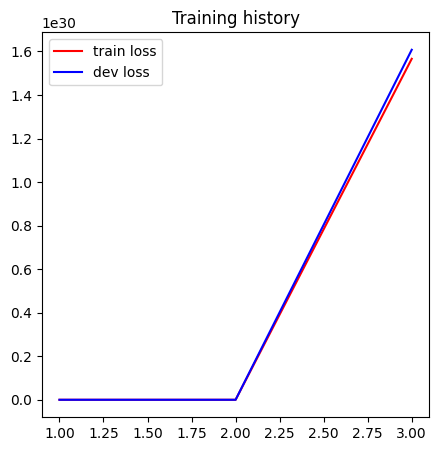

In [11]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

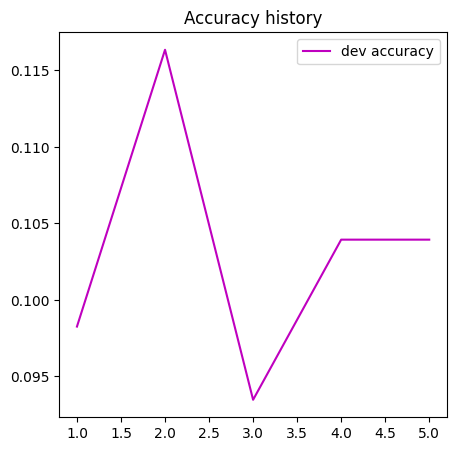

In [12]:
dev_accs = [history[i][2] for i in range(len(history))]
# Plot accuracies
plt.plot([i + 1 for i in range(len(history))], dev_accs, color='m', label='dev accuracy')
plt.legend()
plt.title('Accuracy history')
plt.show()

In [13]:
dev_accs

[0.09825994074344635,
 0.11635299026966095,
 0.09347479045391083,
 0.10394176095724106,
 0.10394176095724106]

In [14]:
updates[0]

{'conv1': {'weight': tensor([[[[nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan]]],
  
  
          [[[nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan]]],
  
  
          [[[nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, n

In [15]:
processed_updates[0]

{'conv1': {'weight': tensor([[[[nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan]]],
  
  
          [[[nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan]]],
  
  
          [[[nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, nan, nan, nan],
            [nan, nan, nan, nan, n

In [16]:
diff_l2_norm(updates[0], processed_updates[0])

tensor(nan)